# Linear classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Data loading

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Gradients

In [4]:

def square(x):
    assert x.shape == (1,), x.shape
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

In [5]:
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

In [7]:
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

In [8]:
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


In [10]:
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### Regularization

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Model training

In [11]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.301968
Epoch 1, loss: 2.301446
Epoch 2, loss: 2.301173
Epoch 3, loss: 2.301028
Epoch 4, loss: 2.300950
Epoch 5, loss: 2.300909
Epoch 6, loss: 2.300886
Epoch 7, loss: 2.300874
Epoch 8, loss: 2.300868
Epoch 9, loss: 2.300864


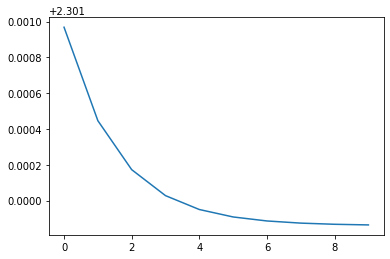

In [21]:
show = plt.plot(loss_history)

In [23]:
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy on v set: ", accuracy)

Accuracy on v set:  0.251


In [24]:
# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-1, batch_size=128, reg=1e-3)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Epoch 0, loss: 8.493746
Epoch 1, loss: 7.686627
Epoch 2, loss: 7.419016
Epoch 3, loss: 5.812184
Epoch 4, loss: 6.828660
Epoch 5, loss: 7.205606
Epoch 6, loss: 8.909157
Epoch 7, loss: 11.121701
Epoch 8, loss: 7.670254
Epoch 9, loss: 6.430701
Accuracy after training for 100 epochs:  0.168


### Choosing best hyper parameters

In [ ]:
num_epochs = 200
batch_size = 256

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
reg_strengths = [1e-3, 1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

for i in learning_rates:
    for j in reg_strengths:
        lc = linear_classifer.LinearSoftmaxClassifier()
        lc.fit(train_X, train_y, epochs=num_epochs, learning_rate=i, batch_size=batch_size, reg=j)
        pred = lc.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print('lr: %f | rs: %f | res: %f' % (i, j, accuracy))
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = lc
            
print('best validation accuracy achieved: %f' % best_val_accuracy)

# Final accuracy

In [25]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear soft-max classifier test set accuracy: %f' % (test_accuracy, ))

Linear soft-max classifier test set accuracy: 0.216000
